<a href="https://colab.research.google.com/github/cjakuc/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [x] Get your model's test accuracy. (One time, at the end.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [x] Do one-hot encoding.
- [x] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [x] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

## 1) Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [7]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
type(df['Date'][0])

str

In [9]:
# Change Date into datetime and check it out
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
print(type(df['Date'][0]))
df['Date'].describe()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


count                     421
unique                    169
top       2016-08-30 00:00:00
freq                       29
first     2011-05-16 00:00:00
last      2026-04-25 00:00:00
Name: Date, dtype: object

In [0]:
# Create the year cutoff for train, validation, and test subsets
cutoff_train = pd.to_datetime('2017-01-01')
cutoff_val = pd.to_datetime('2018-01-01')
cutoff_test = pd.to_datetime('2019-01-01')

In [0]:
train = df[df['Date'] < cutoff_train]
val = df[(df['Date'] > cutoff_train) & (df['Date'] < cutoff_val)]
test = df[(df['Date'] > cutoff_val) & (df['Date'] < cutoff_test)]

In [12]:
# Check out the datasets
print(train.sample(5))
print(val.sample(5))
print(test.sample(5))

        Burrito       Date  Yelp  Google  ... Avocado  Corn  Zucchini  Great
186  California 2016-08-17   NaN     NaN  ...     NaN   NaN       NaN   True
266       Other 2016-10-27   NaN     NaN  ...     NaN   NaN       NaN  False
219       Other 2016-08-30   NaN     NaN  ...     NaN   NaN       NaN   True
54        Other 2016-04-02   4.0     4.4  ...     NaN   NaN       NaN   True
124       Other 2016-05-29   NaN     NaN  ...     NaN   NaN       NaN   True

[5 rows x 59 columns]
        Burrito       Date  Yelp  Google  ... Avocado  Corn  Zucchini  Great
368  California 2017-08-07   NaN     NaN  ...     NaN   NaN       NaN   True
350  California 2017-05-30   NaN     NaN  ...     NaN   NaN       NaN  False
303       Other 2017-01-07   NaN     NaN  ...     NaN   NaN       NaN  False
311       Other 2017-01-15   NaN     NaN  ...     NaN   NaN       NaN   True
341       Other 2017-05-13   4.5     5.0  ...     NaN   NaN       NaN  False

[5 rows x 59 columns]
         Burrito       Date  Y

## 2) Begin with baselines for classification.

In [13]:
train['Great'] = train['Great'].replace({False:0,True:1})
val['Great'] = val['Great'].replace({False:0,True:1})
test['Great'] = test['Great'].replace({False:0,True:1})
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)
y_val = val[target]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [0]:
# Determine the majority class
majority_class = y_train.mode()[0]
y_pred = [majority_class]*len(y_train)

In [15]:
# Find baseline accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_train,y_pred)

0.5906040268456376

## 3) Use scikit-learn for logistic regression.

In [0]:
# Import estimator
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [0]:
# Instantiate the class
log_reg = LogisticRegressionCV()

In [18]:
# Look at features to choose from
train.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [19]:
# Look at value counts of beef, pico, guac, cheese, fries, sour cream, pork,
# chicken, shrimp, fish, rice, beans, lettuce, tomato, bell pepper, and sauce
print(train['Beef'].value_counts(dropna=False))
print(train['Pico'].value_counts(dropna=False))
print(train['Guac'].value_counts(dropna=False))
print(train['Cheese'].value_counts(dropna=False))
print(train['Fries'].value_counts(dropna=False))
print(train['Sour cream'].value_counts(dropna=False))
print(train['Pork'].value_counts(dropna=False))
print(train['Chicken'].value_counts(dropna=False))
print(train['Shrimp'].value_counts(dropna=False))
print(train['Fish'].value_counts(dropna=False))
print(train['Rice'].value_counts(dropna=False))
print(train['Beans'].value_counts(dropna=False))
print(train['Lettuce'].value_counts(dropna=False))
print(train['Tomato'].value_counts(dropna=False))
print(train['Bell peper'].value_counts(dropna=False))
print(train['Sauce'].value_counts(dropna=False))

x      130
NaN    130
X       38
Name: Beef, dtype: int64
NaN    155
x      115
X       28
Name: Pico, dtype: int64
NaN    159
x      101
X       38
Name: Guac, dtype: int64
NaN    149
x      121
X       28
Name: Cheese, dtype: int64
NaN    179
x       97
X       22
Name: Fries, dtype: int64
NaN    213
x       63
X       22
Name: Sour cream, dtype: int64
NaN    255
x       29
X       14
Name: Pork, dtype: int64
NaN    278
x       19
X        1
Name: Chicken, dtype: int64
NaN    278
x       17
X        3
Name: Shrimp, dtype: int64
NaN    293
x        3
X        2
Name: Fish, dtype: int64
NaN    265
x       24
X        9
Name: Rice, dtype: int64
NaN    266
x       24
X        8
Name: Beans, dtype: int64
NaN    287
x        9
X        2
Name: Lettuce, dtype: int64
NaN    291
x        5
X        2
Name: Tomato, dtype: int64
NaN    291
x        4
X        3
Name: Bell peper, dtype: int64
NaN    261
x       33
X        4
Name: Sauce, dtype: int64


In [20]:
# Clean/encode beef, pico, guac, cheese, fries, sour cream, pork, chicken, shrimp,
# fish, rice, beans, lettuce, tomato, bell pepper, and sauce
import numpy as np
to_clean = ['Beef','Pico','Guac','Cheese','Fries','Sour cream','Pork',
            'Chicken','Shrimp','Fish','Rice','Beans','Lettuce','Tomato',
            'Bell peper','Sauce']
for var in to_clean:
  train[var] = train[var].replace({'x':1,'X':1,np.NaN:0})
  val[var] = val[var].replace({'x':1,'X':1,np.NaN:0})
  test[var] = test[var].replace({'x':1,'X':1,np.NaN:0})


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [0]:
# Arrange X feature matrices
features = ['Yelp',
            'Google',
            'Cost',
            'Hunger',
            'Tortilla',
            'Temp',
            'Meat',
            'Fillings',
            'Uniformity',
            'Salsa',
            'Synergy',
            'Wrap',
            'Beef','Pico','Guac','Cheese','Fries','Sour cream','Pork',
            'Chicken','Shrimp','Fish','Rice','Beans','Lettuce','Tomato',
            'Bell peper','Sauce']
X_train = train[features]
X_val = val[features]

In [0]:
# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
# Standardize the x values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [25]:
# Fit the model
log_reg.fit(X_train_scaled,
            y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

## 4) Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [26]:
# Get the validation accuracy
print('Validation Accuracy:', log_reg.score(X_val_scaled,
                                           y_val))

Validation accuracy 0.8


## 5) Get your model's test accuracy. (One time, at the end.)

In [27]:
# Get the test accuracy
X_test = test[features]
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = log_reg.predict(X_test_scaled)
y_test = test[target]
print('Test Accuracy:' ,log_reg.score(X_test_scaled,
                                      y_test))

Test Accuracy: 0.7777777777777778


## Plot the coefficients

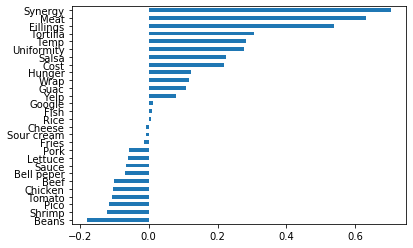

In [32]:
%matplotlib inline
coefficients = pd.Series(log_reg.coef_[0],
                         X_train.columns)
coefficients.sort_values().plot.barh();

## Do feature selection w/ SelectKBest

In [0]:
from sklearn.feature_selection import SelectKBest

for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(k=k)
  X_train_selected = selector.fit_transform(X_train_scaled,
                                            y_train)
  X_val_selected = selector.transform(X_val_scaled)

  kbest_model = LogisticRegressionCV()
  kbest_model.fit(X_train_selected,
                  y_train)
  y_pred = kbest_model.predict(X_val_selected)
  print(f'Validation Accuracy: {kbest_model.score(X_val_selected,y_val)} \n')
# 3 Features has the highest accuracy
# Lets try the same thing with test instead of validation data

In [37]:
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(k=k)
  X_train_selected = selector.fit_transform(X_train_scaled,
                                            y_train)
  X_test_selected = selector.transform(X_test_scaled)

  kbest_model = LogisticRegressionCV()
  kbest_model.fit(X_train_selected,
                  y_train)
  y_pred = kbest_model.predict(X_test_selected)
  print(f'Test Accuracy: {kbest_model.score(X_test_selected,y_test)} \n')
# 16 Features has the highest accuracy w/ the least features

1 features
Test Accuracy: 0.7037037037037037 

2 features
Test Accuracy: 0.6296296296296297 

3 features
Test Accuracy: 0.7037037037037037 

4 features
Test Accuracy: 0.6296296296296297 

5 features
Test Accuracy: 0.7037037037037037 

6 features
Test Accuracy: 0.7037037037037037 

7 features
Test Accuracy: 0.7407407407407407 

8 features
Test Accuracy: 0.7777777777777778 

9 features
Test Accuracy: 0.7777777777777778 

10 features
Test Accuracy: 0.7407407407407407 

11 features
Test Accuracy: 0.7777777777777778 

12 features
Test Accuracy: 0.7777777777777778 

13 features
Test Accuracy: 0.7777777777777778 

14 features
Test Accuracy: 0.7777777777777778 

15 features
Test Accuracy: 0.7777777777777778 

16 features
Test Accuracy: 0.8148148148148148 

17 features
Test Accuracy: 0.8148148148148148 

18 features
Test Accuracy: 0.8148148148148148 

19 features
Test Accuracy: 0.8148148148148148 

20 features
Test Accuracy: 0.8148148148148148 

21 features
Test Accuracy: 0.7777777777777778 

2

In [66]:
# What are the 16 best features?
selector = SelectKBest(k=16)
X_train_selected = selector.fit_transform(X_train_scaled,
                                          y_train)
X_test_selected = selector.transform(X_test_scaled)

kbest_model = LogisticRegressionCV()
kbest_model.fit(X_train_selected,
                y_train)
y_pred = kbest_model.predict(X_test_selected)
# Use selector.get_support to make a mask of the selected features
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
print(f'Features: {selected_names} \n with a Test Accuracy of {kbest_model.score(X_test_selected,y_test)}')

Features: Index(['Yelp', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Pico', 'Chicken', 'Shrimp',
       'Rice', 'Beans'],
      dtype='object') 
 with a Test Accuracy of 0.8148148148148148
